The runtime notebook should allow the user to select a saved protocol for each of the two heaters. The user should be able to view the selected protocols. Once the protocols have been selected, the PCR run should commence with the click of a start button and run until either (1) normal completion or (2) the user presses a stop button. A record of the run should be recorded to a data file.

Feedforward Control

In [10]:
pip install cvxpy

  Using cached https://files.pythonhosted.org/packages/d2/a2/31b8c02a1b722f3713a0ea24ef8484c7f51edb0a73d44a0504140d0a624a/cvxpy-1.0.31-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1a/72/33be87cce255d4e9dbbfef547e9fd6ec7ee94d0d0910bb2b13badea3fbbe/scs-2.1.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/b9/3a/59aa93b573a22fda44402383aeddcc2a081c31e61080af3da9d11855c77a/ecos-2.0.7.post1.tar.gz
  Created wheel for scs: filename=scs-2.1.2-cp37-cp37m-macosx_10_9_x86_64.whl size=118826 sha256=d5970d9648cfd3c25942e7c091b39776b55949e3b9bd14896dc46f8801b85110
  Stored in directory: /Users/jessidirk/Library/Caches/pip/wheels/df/d0/79/37ea880586da03c620ca9ecd5e42adbd86bc6ea84363965c5f
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp37-cp37m-macosx_10_9_x86_64.whl size=83996 sha256=80253c9c0c205f68b7cd14bec06e0dcda855effc63a333b96386d31a30fe3cca
  Stored in directory: /Users/jessidirk/Library/Caches/pip/wheels/4b/7d/90/39ff7dca0e5c06

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import linprog
import cvxpy as cp
import ipywidgets as widgets
import tclab
import threading
import datetime
import glob
import pandas as pd
from scipy import interpolate

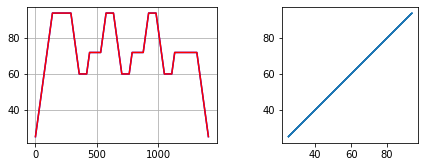

In [2]:
def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1(t), u2(t))
        ax[1].axis('square')
        r = lambda t: np.array([u1(t), u2(t)])
        return u1, u2, r

SP1, SP2, r = get_data('PCR/Heater1Protocol.csv', 'PCR/Heater2Protocol.csv')

## Feedforward Control with PID Trim

### Feedforward Function

In [3]:
# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = SP1(0)
Q_ps = 10
Q1_max = 3.3
Q2_max = 3.3
T_ub = 100

def feedforward(SP1, SP2, Ta):
    c = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    A_ub = np.array([
        [1, 1, 0, 0, 0, 0, 0, 0]
    ])
    b_ub = np.array([Q_ps])
    A_eq = np.array([
        [-1, 0, (Ua + Ub), -Ub, 0, 0, 0, 0],
        [0, -1, -Ub, (Ua + Ub), 0, 0, 0, 0],
        [0, 0, 1, 0, -1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, -1, 1]
    ])
    b_eq = np.array([Ua*Ta, Ua*Ta, SP1, SP2])
    bounds = [(0, Q1_max), (0, Q2_max), (Ta, T_ub), (Ta, T_ub), (0, None), (0, None), (0, None), (0, None)]
    results = linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
    Q1, Q2, T1, T2, _, _, _, _ = results.x
    return [Q1, Q2, T1, T2]

### Feedback Function

In [6]:
class PID:
    def __init__(self, kp=0.5, ki=0.5, kd=0.5, dt=1):
        self.kp = kp
        self.ki = ki
        self.kd = kd

        self.e = 0
        self.e_prev = 0
        self.dt = dt
        
        self.P = 0
        self.I = 0
        self.D = 0
        
    def update(self, sp, pv):
        e = sp - pv
        self.e = e
        
        self.P = self.kp * self.e
        self.I += (self.e*self.ki*self.dt)
        self.D = self.kd * (self.e - self.e_prev)/self.dt
        
        self.mv = self.P + self.I + self.D
        self.e_prev = e
        
        return self.mv

In [10]:
%matplotlib inline

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: SP1(t)),
                ('SP2', lambda: SP1(t))
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 2000, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
            feedback1 = PID(1, 0, 0.1, 5)
            feedback2 = PID(3, 0, 0.5, 5)

            # run
            for t in tclab.clock(2000, 5):
                Q1_ff, Q2_ff, T1, T2 = feedforward(SP1(t), SP2(t), Ta)
                Q1_fb = feedback1.update(SP1(t), lab.T1)
                Q2_fb = feedback2.update(SP2(t), lab.T2)
                lab.U1 = 100*(Q1_ff + Q1_fb)/lab.P1/0.013
                lab.U2 = 100*(Q2_ff + Q2_fb)/lab.P2/0.013
                p.update(t)
                if stop.value:
                    break

            # post-run
            fname = datetime.datetime.now().strftime("Data/data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)
            
# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
display(output_plotter)           

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))

## Feedforward Setpoint Tracking Control with PID Trim

### Feedforward Model Estimation

In [20]:
# parameter values
Ua = 0.036
Ub = 0.010
Uc = 0.08
CpH = 4.9
CpS = 1.26
Ta = SP1(0)
umax = 3.3
uPS = 10
xmax = 100 - Ta
IC = np.array([0, 0, 0, 0])

# system matrices
A = np.array([[-(Ua+Ub+Uc)/CpH, Uc/CpH, Ub/CpH, 0],
    [Uc/CpS, -Uc/CpS, 0, 0],
    [Ub/CpH, 0, -(Ua+Ub+Uc)/CpH, Uc/CpH],
    [0, 0, Uc/CpS, -Uc/CpS]])
B = np.array([[1/CpH, 0], [0, 0], [0, 1/CpH], [0, 0]])
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
D = np.array([[0, 0], [0, 0]])

# time grid
dt = 5
tf = 2000
t, dt = np.linspace(0, tf, int(tf/dt) + 1, retstep=True)

# discrete-time approximation
Ad = np.eye(4) + dt*A
Bd = dt*B

# decision variables
K = len(t)
u = cp.Variable((K, 2))
x = cp.Variable((K, 4))
y = cp.Variable((K, 2))

# objective

objective = cp.Minimize(sum([cp.norm2(r(t[k]) - Ta - y[k])**2 for k in range(0, K)]))

# constraints
constraints = [x[0] == IC]
constraints += [x[k+1] == Ad @ x[k] + Bd @ u[k] for k in range(0, K-1)]
constraints += [y[k] == C @ x[k] + D @ u[k] for k in range(0, K)]
constraints += [x[k] <= xmax for k in range(0, K)]
constraints += [u[k] >= 0 for k in range(0, K)]
constraints += [u[k] <= umax for k in range(0, K)]
constraints += [sum(u[k]) <= uPS for k in range(0, K)]

# solve
prob = cp.Problem(objective, constraints)
prob.solve()

u = interpolate.interp1d(t, u.value, axis=0, fill_value="extrapolate")
tsim = np.linspace(0, tf, int(tf)+1)
usim = [u(t) for t in tsim]

### Feedback Function

In [21]:
class PID:
    def __init__(self):
        self.kp = 0.5
        self.ki = 0.5
        self.kd = 0.5

        self.e = 0
        self.e_prev = 0
        self.dt = 1
        
        self.P = 0
        self.I = 0
        self.D = 0
        
    def update(self, sp, pv):
        e = sp - pv
        self.e = e
        
        self.P = self.kp * self.e
        self.I += self.ki * self.e
        self.D = self.kd * (self.e - self.e_prev)/self.dt
        
        self.mv = self.P + self.I + self.D
        self.e_prev = e
        
        return self.mv

In [23]:
TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: SP1(t)),
                ('SP2', lambda: SP1(t))
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 2000, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
            feedback1 = PID()
            feedback1.kp = 3
            feedback1.ki = 0
            feedback1.kd = 0.5
            feedback1.dt = 5
            feedback2 = PID()
            feedback2.kp = 3
            feedback2.ki = 0
            feedback2.kd = 0.5
            feedback2.dt = 5
    
            # run
            for t in tclab.clock(2000, 5):
                x = int(t)
                Q1_ff, Q2_ff = usim[x]
                Q1_fb = feedback1.update(SP1(t), lab.T1)
                Q2_fb = feedback2.update(SP2(t), lab.T2)
                lab.U1 = 100*(Q1_ff + Q1_fb)/lab.P1/0.013
                lab.U2 = 100*(Q2_ff + Q2_fb)/lab.P2/0.013
                lab.U1 = 100*((Q1_ff/umax)*(Q1_fb/(lab.P1*0.013)))
                lab.U2 = 100*((Q2_ff/umax)*(Q2_fb/(lab.P1*0.013)))
                p.update(t)
                if stop.value:
                    break

            # post-run
            fname = datetime.datetime.now().strftime("Data/data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)
            
# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
display(output_plotter)           

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))